In [6]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from PIL import Image

# Paths and Parameters
root_dir = "/kaggle/input/cervical-cancer-largest-dataset-sipakmed/"
paths = [
    os.path.join(root_dir, "im_Dyskeratotic", "im_Dyskeratotic", "CROPPED"),
    os.path.join(root_dir, "im_Koilocytotic", "im_Koilocytotic", "CROPPED"),
    os.path.join(root_dir, "im_Metaplastic", "im_Metaplastic", "CROPPED"),
    os.path.join(root_dir, "im_Parabasal", "im_Parabasal", "CROPPED"),
    os.path.join(root_dir, "im_Superficial-Intermediate", "im_Superficial-Intermediate", "CROPPED")
]

height, width, channels = 64, 64, 3
num_classes = len(paths)

# Load images from folders
def load_images_from_paths(paths, img_size=(height, width)):
    images = []
    labels = []
    valid_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.gif')
    for idx, p in enumerate(paths):
        if not os.path.exists(p):
            print(f"Warning: path not found {p}")
            continue
        for file in os.listdir(p):
            if not file.lower().endswith(valid_extensions):
                continue
            try:
                img_path = os.path.join(p, file)
                img = Image.open(img_path).convert('RGB').resize(img_size)
                img = np.array(img).astype(np.float32) / 255.0
                if img.shape != (height, width, channels):
                    continue
                images.append(img)
                labels.append(idx)
            except Exception as e:
                print(f"Failed loading {file}: {e}")
                continue
    return np.array(images, dtype=np.float32), np.array(labels, dtype=np.int32)

# Load data and labels
data, labels = load_images_from_paths(paths)

# One-hot labels for training neural net
labels_one_hot = tf.one_hot(labels, depth=num_classes).numpy()

# Train/val/test split
X_train, X_tmp, y_train, y_tmp = train_test_split(data, labels_one_hot, test_size=0.3, random_state=42, stratify=labels)
X_val, X_test, y_val, y_test = train_test_split(X_tmp, y_tmp, test_size=0.5, random_state=42, stratify=np.argmax(y_tmp, axis=1))

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)
datagen.fit(X_train)

# Load ResNet-101 with pre-trained weights
base_model = ResNet101(weights="imagenet", include_top=False, input_shape=(height, width, channels))

# Freeze base model layers
base_model.trainable = False

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
output = Dense(num_classes, activation="softmax")(x)

# Create the model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss="categorical_crossentropy",
              metrics=["accuracy"])

# Train the model
batch_size = 64
epochs = 200

history = model.fit(
    datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_val, y_val),
    steps_per_epoch=len(X_train) // batch_size,
    epochs=epochs
)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")


171458560/171446536 [==============================] - 1s 0us/step
Epoch 1/200
44/44 [==============================] - 10s 122ms/step - loss: 1.7690 - accuracy: 0.2029 - val_loss: 1.6089 - val_accuracy: 0.2059
Epoch 2/200
44/44 [==============================] - 3s 78ms/step - loss: 1.7021 - accuracy: 0.1877 - val_loss: 1.6058 - val_accuracy: 0.2208
Epoch 3/200
44/44 [==============================] - 3s 78ms/step - loss: 1.6889 - accuracy: 0.1884 - val_loss: 1.6019 - val_accuracy: 0.2323
Epoch 4/200
44/44 [==============================] - 3s 78ms/step - loss: 1.6672 - accuracy: 0.1910 - val_loss: 1.5989 - val_accuracy: 0.2488
Epoch 5/200
44/44 [==============================] - 4s 80ms/step - loss: 1.6365 - accuracy: 0.2123 - val_loss: 1.5962 - val_accuracy: 0.3937
Epoch 6/200
44/44 [==============================] - 4s 80ms/step - loss: 1.6382 - accuracy: 0.2004 - val_loss: 1.5938 - val_accuracy: 0.2175
Epoch 7/200
44/44 [==============================] - 3s 78ms/step - loss: 1.623

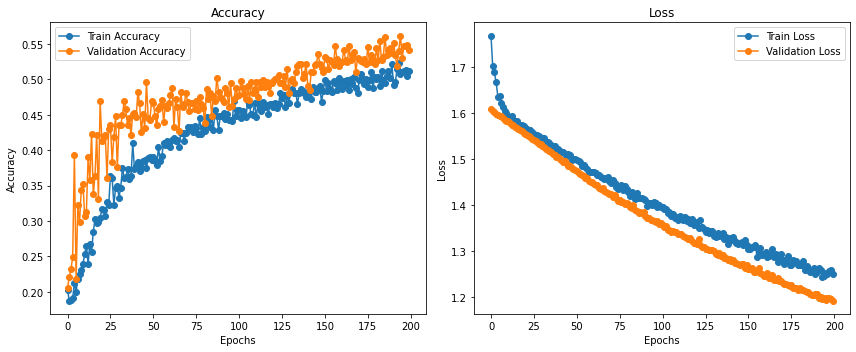

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# --- Visualize Training History ---
plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.legend()
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.legend()
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()



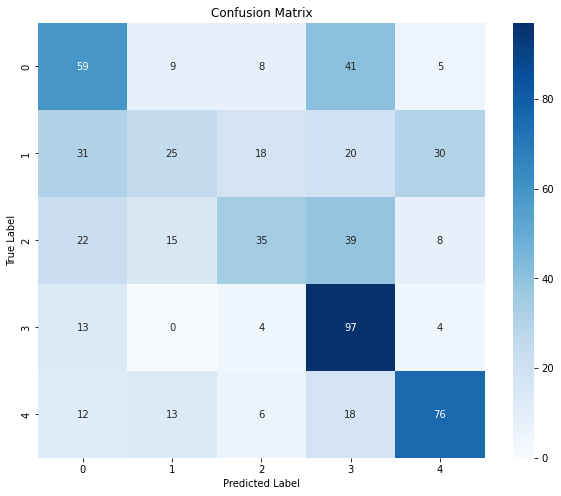

In [3]:
# --- Ma trận nhầm lẫn ---
# Chuyển đổi nhãn thực tế và dự đoán về dạng không one-hot
y_test_int = np.argmax(y_test, axis=1)
y_test_pred = np.argmax(model.predict(X_test), axis=1)

# Tạo ma trận nhầm lẫn
cm = confusion_matrix(y_test_int, y_test_pred)

# Vẽ heatmap cho ma trận nhầm lẫn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=range(num_classes),
            yticklabels=range(num_classes))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

10 test predictions vs actual labels:
Prediction: 3, Actual: 3
Prediction: 3, Actual: 1
Prediction: 3, Actual: 0
Prediction: 2, Actual: 3
Prediction: 3, Actual: 3
Prediction: 0, Actual: 2
Prediction: 0, Actual: 0
Prediction: 4, Actual: 4
Prediction: 4, Actual: 4
Prediction: 0, Actual: 0


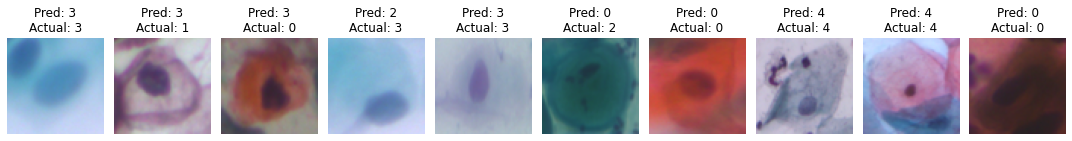

In [5]:
# --- In ra 10 giá trị dự đoán và thực tế từ tập test ---
print("10 test predictions vs actual labels:")
for i in range(10):
    print(f"Prediction: {y_test_pred[i]}, Actual: {y_test_int[i]}")

# --- Hiển thị ảnh cùng dự đoán và nhãn thực tế ---
def display_images_with_predictions(X_test, y_test_pred, y_test_int, num_images=10):
    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(X_test[i])
        plt.title(f"Pred: {y_test_pred[i]}\nActual: {y_test_int[i]}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# Gọi hàm để hiển thị hình ảnh
display_images_with_predictions(X_test, y_test_pred, y_test_int, num_images=10)